In [125]:
import os
import numpy as np
import pandas as pd
# from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.manifold import TSNE

import mindscope_utilities
import mindscope_utilities.visual_behavior_ophys as ophys

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

pd.set_option('display.max_columns', 500)

In [2]:
data_storage_directory = r"C:\temp"  # Note: this path must exist on your local drive
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_storage_directory)

# Find repetitive cells

In [21]:
cells_table = cache.get_ophys_cells_table()
cells_table

,cell_specimen_id,ophys_experiment_id
cell_roi_id,,
1080884343,1086496928,775614751
1080884173,1086496914,775614751
1080883843,1086496838,775614751
1080886674,1086491756,775614751
1080885658,1086491699,775614751
...,...,...
1115385589,1120127229,1110928073
1115385513,1120127083,1110928073
1115301580,1120126794,1110928075


In [8]:
uniqueCellIDs, uniqueCellCount = np.unique(cells_table['cell_specimen_id'], return_counts=True)

(array([2.3287e+04, 6.8020e+03, 5.1330e+03, 4.5390e+03, 4.4020e+03,
        4.3810e+03, 1.2170e+03, 6.0600e+02, 1.0600e+02, 1.6000e+01]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 <BarContainer object of 10 artists>)

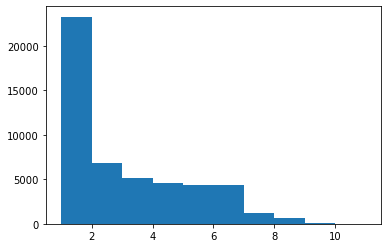

In [94]:
plt.hist(uniqueCellCount)

In [20]:
# select cells repeat more than 5 times
repeatCount = 5
cells_table_selected = cells_table.loc[cells_table['cell_specimen_id'].isin(uniqueCellIDs[uniqueCellCount > repeatCount])]
cells_table_selected

,cell_specimen_id,ophys_experiment_id
cell_roi_id,,
1080905923,1086540341,792813858
1080905907,1086539950,792813858
1080905893,1086539623,792813858
1080905876,1086539275,792813858
1080905830,1086537218,792813858
...,...,...
1115365254,1120128890,1108445073
1115365250,1120128823,1108445073
1115365243,1120128748,1108445073


In [63]:
experiment_table = cache.get_ophys_experiment_table()
cells_meta_table_selected = cells_table_selected.copy()
metadata_keys = [
        'ophys_session_id',
        'imaging_depth',
        'targeted_structure',
        'session_type',
        'experience_level',
        'passive',
        'image_set',
        'full_genotype',
        'mouse_id',
        'sex',
    ]

for experimentID in tqdm(cells_table_selected['ophys_experiment_id'].unique()):
    # Somehow some experiments in cell table are not in ophys table. 
    if len(experiment_table.query('ophys_experiment_id == @experimentID')) != 1:
        continue
    for metadata_key in metadata_keys:
        cells_meta_table_selected.loc[cells_meta_table_selected.ophys_experiment_id == experimentID, metadata_key] = \
            experiment_table.query('ophys_experiment_id == @experimentID')[metadata_key].values[0]
        
        
        

  0%|          | 0/1477 [00:00<?, ?it/s]

In [65]:
cells_meta_table_selected

,cell_specimen_id,ophys_experiment_id,ophys_session_id,imaging_depth,targeted_structure,session_type,experience_level,passive,image_set,full_genotype,mouse_id,sex
cell_roi_id,,,,,,,,,,,,
1080905923,1086540341,792813858,7.923273e+08,375.0,VISp,OPHYS_1_images_A,Familiar,False,A,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,412366.0,F
1080905907,1086539950,792813858,7.923273e+08,375.0,VISp,OPHYS_1_images_A,Familiar,False,A,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,412366.0,F
1080905893,1086539623,792813858,7.923273e+08,375.0,VISp,OPHYS_1_images_A,Familiar,False,A,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,412366.0,F
1080905876,1086539275,792813858,7.923273e+08,375.0,VISp,OPHYS_1_images_A,Familiar,False,A,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,412366.0,F
1080905830,1086537218,792813858,7.923273e+08,375.0,VISp,OPHYS_1_images_A,Familiar,False,A,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,412366.0,F
...,...,...,...,...,...,...,...,...,...,...,...,...
1115365254,1120128890,1108445073,1.108352e+09,175.0,VISl,OPHYS_6_images_H,Novel >1,False,H,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,563231.0,F
1115365250,1120128823,1108445073,1.108352e+09,175.0,VISl,OPHYS_6_images_H,Novel >1,False,H,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,563231.0,F
1115365243,1120128748,1108445073,1.108352e+09,175.0,VISl,OPHYS_6_images_H,Novel >1,False,H,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,563231.0,F


In [193]:
def selectRepeatedCells(df, countTot = 10):

    selectedCells = pd.DataFrame({})
    count = 0
    for i in range(len(df)):
        if count >= countTot:
            break
        cell = df.iloc[i]
        restCells = df.iloc[np.arange(i+1, len(df))]
        nextAppearance = restCells.loc[restCells.cell_specimen_id == cell.cell_specimen_id]
        if len(nextAppearance) > 0:
            nextAppearance = nextAppearance.iloc[0]
        else:
            continue
        if ('OPHYS_1' in cell.session_type) and ('OPHYS_4' in nextAppearance.session_type):
            selectedCells = pd.concat([selectedCells, cell, nextAppearance], axis = 1)
            count += 1
    return selectedCells.T

In [207]:
cellType = 'Sst'

selectedCells = cells_meta_table_selected.copy()
selectedCells = selectedCells.loc[selectedCells['full_genotype'].str.contains(cellType, na = False)]
selectedCells = selectedCells.query('passive == False')
selectedCells = selectedCells.loc[selectedCells['session_type'].str.contains('OPHYS_1_images_A', na = False) | \
                                  selectedCells['session_type'].str.contains('OPHYS_4_images_B', na = False)]
selectedCells = selectedCells.query('targeted_structure == "VISp"')

uniqueCellIDs, uniqueCellCount = np.unique(selectedCells['cell_specimen_id'], return_counts=True)
selectedCells = selectedCells.loc[selectedCells['cell_specimen_id'].isin(uniqueCellIDs[uniqueCellCount > 1])]

selectedCells = selectRepeatedCells(selectedCells, countTot = 20)

selectedCells.to_pickle(r'./.data/selectedCellTables//' + cellType + r'.pkl')
selectedCells.to_csv(r'./.data/selectedCellTables//' + cellType + r'.csv')
selectedCells.head(20)

,cell_specimen_id,ophys_experiment_id,ophys_session_id,imaging_depth,targeted_structure,session_type,experience_level,passive,image_set,full_genotype,mouse_id,sex
1080851174,1086559206,850517346,849304162.0,175.0,VISp,OPHYS_1_images_A,Familiar,False,A,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,440631.0,M
1080851982,1086559206,853363743,852794141.0,175.0,VISp,OPHYS_4_images_B,Novel 1,False,B,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,440631.0,M
1080851169,1086559064,850517346,849304162.0,175.0,VISp,OPHYS_1_images_A,Familiar,False,A,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,440631.0,M
1080851952,1086559064,853363743,852794141.0,175.0,VISp,OPHYS_4_images_B,Novel 1,False,B,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,440631.0,M
1080851157,1086558510,850517346,849304162.0,175.0,VISp,OPHYS_1_images_A,Familiar,False,A,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,440631.0,M
1080851971,1086558510,853363743,852794141.0,175.0,VISp,OPHYS_4_images_B,Novel 1,False,B,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,440631.0,M
1080851117,1086557304,850517346,849304162.0,175.0,VISp,OPHYS_1_images_A,Familiar,False,A,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,440631.0,M
1080851929,1086557304,853363743,852794141.0,175.0,VISp,OPHYS_4_images_B,Novel 1,False,B,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,440631.0,M
1080851111,1086557083,850517346,849304162.0,175.0,VISp,OPHYS_1_images_A,Familiar,False,A,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,440631.0,M
1080852000,1086557083,853363743,852794141.0,175.0,VISp,OPHYS_4_images_B,Novel 1,False,B,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,440631.0,M


# Find required experiments that contains the cells of interest
### Final selection of cells of interest based on cell type/is_passive/depth/location etc
### And load the calcium traces


In [584]:
cellType = 'Slc'
selectedCells = pd.read_pickle(r'./.data/selectedCellTables//' + cellType + r'.pkl')

metadata_keys = [
        'timestamps',
        'dff',
        'events',
        'filtered_events',
    ]
for metadata_key in metadata_keys:
    selectedCells[metadata_key] = [[1]]*len(selectedCells)
selectedCells['stimulus'] = [[1]]*len(selectedCells)
    
    
requiredExperiment = np.unique(selectedCells.ophys_experiment_id)
for experimentID in tqdm(requiredExperiment):
    experimentsData = cache.get_behavior_ophys_experiment(experimentID)
    
    experiment_neural_data = ophys.build_tidy_cell_df(experimentsData)

    # add some columns with metadata for the experiment
    selectedCellsThisExperiment = selectedCells.loc[selectedCells.ophys_experiment_id == experimentID]

    for metadata_key in metadata_keys:
        for icell in range(len(selectedCellsThisExperiment)):
            cellID = selectedCellsThisExperiment.iloc[icell].cell_specimen_id
            cellData = experiment_neural_data.query('cell_specimen_id == @cellID')


            rowID = np.where((selectedCells.cell_specimen_id == cellID) & \
                                           (selectedCells.ophys_experiment_id == experimentID))[0][0]
            selectedCells[metadata_key].iloc[rowID] = cellData[metadata_key]


            selectedCells['stimulus'].iloc[rowID] = experimentsData.stimulus_presentations
selectedCells.to_pickle(r'./.data/selectedCellExperimentTables//' + cellType + r'.pkl')

  0%|          | 0/2 [00:00<?, ?it/s]


behavior_ophys_experiment_795076128.nwb:   0%|                                            | 0.00/1.16G [00:00<?, ?MB/s]
behavior_ophys_experiment_795076128.nwb:   0%|                                | 1.02k/1.16G [00:00<82:57:26, 3.88kMB/s]
behavior_ophys_experiment_795076128.nwb:   0%|                                  | 51.2k/1.16G [00:00<1:59:01, 162kMB/s]
behavior_ophys_experiment_795076128.nwb:   0%|                                     | 295k/1.16G [00:00<22:19, 864kMB/s]
behavior_ophys_experiment_795076128.nwb:   0%|                                    | 817k/1.16G [00:00<09:05, 2.12MMB/s]
behavior_ophys_experiment_795076128.nwb:   0%|                                   | 1.78M/1.16G [00:00<04:26, 4.34MMB/s]
behavior_ophys_experiment_795076128.nwb:   0%|▏                                  | 4.93M/1.16G [00:00<01:32, 12.4MMB/s]
behavior_ophys_experiment_795076128.nwb:   1%|▎                                  | 12.3M/1.16G [00:00<00:40, 28.2MMB/s]
behavior_ophys_experiment_795076128.nwb

behavior_ophys_experiment_795076128.nwb:  20%|███████                             | 227M/1.16G [00:09<00:47, 19.7MMB/s]
behavior_ophys_experiment_795076128.nwb:  20%|███████▏                            | 229M/1.16G [00:09<00:46, 20.0MMB/s]
behavior_ophys_experiment_795076128.nwb:  20%|███████▏                            | 232M/1.16G [00:10<00:46, 20.1MMB/s]
behavior_ophys_experiment_795076128.nwb:  20%|███████▎                            | 234M/1.16G [00:10<00:45, 20.4MMB/s]
behavior_ophys_experiment_795076128.nwb:  20%|███████▎                            | 237M/1.16G [00:10<00:44, 20.5MMB/s]
behavior_ophys_experiment_795076128.nwb:  21%|███████▍                            | 239M/1.16G [00:10<00:44, 20.8MMB/s]
behavior_ophys_experiment_795076128.nwb:  21%|███████▌                            | 242M/1.16G [00:10<00:44, 20.7MMB/s]
behavior_ophys_experiment_795076128.nwb:  21%|███████▌                            | 244M/1.16G [00:10<00:45, 20.1MMB/s]
behavior_ophys_experiment_795076128.nwb:

behavior_ophys_experiment_795076128.nwb:  33%|███████████▉                        | 385M/1.16G [00:17<00:37, 20.7MMB/s]
behavior_ophys_experiment_795076128.nwb:  33%|████████████                        | 387M/1.16G [00:17<00:36, 21.3MMB/s]
behavior_ophys_experiment_795076128.nwb:  34%|████████████▏                       | 390M/1.16G [00:17<00:35, 21.6MMB/s]
behavior_ophys_experiment_795076128.nwb:  34%|████████████▏                       | 392M/1.16G [00:17<00:35, 21.5MMB/s]
behavior_ophys_experiment_795076128.nwb:  34%|████████████▎                       | 394M/1.16G [00:17<00:35, 21.5MMB/s]
behavior_ophys_experiment_795076128.nwb:  34%|████████████▎                       | 396M/1.16G [00:17<00:35, 21.5MMB/s]
behavior_ophys_experiment_795076128.nwb:  34%|████████████▍                       | 399M/1.16G [00:17<00:34, 21.9MMB/s]
behavior_ophys_experiment_795076128.nwb:  35%|████████████▍                       | 401M/1.16G [00:18<00:35, 21.1MMB/s]
behavior_ophys_experiment_795076128.nwb:

behavior_ophys_experiment_795076128.nwb:  48%|█████████████████▎                  | 556M/1.16G [00:24<00:20, 29.3MMB/s]
behavior_ophys_experiment_795076128.nwb:  48%|█████████████████▍                  | 559M/1.16G [00:24<00:20, 28.9MMB/s]
behavior_ophys_experiment_795076128.nwb:  49%|█████████████████▍                  | 562M/1.16G [00:24<00:20, 28.7MMB/s]
behavior_ophys_experiment_795076128.nwb:  49%|█████████████████▌                  | 565M/1.16G [00:24<00:20, 28.9MMB/s]
behavior_ophys_experiment_795076128.nwb:  49%|█████████████████▋                  | 569M/1.16G [00:24<00:19, 30.6MMB/s]
behavior_ophys_experiment_795076128.nwb:  49%|█████████████████▊                  | 572M/1.16G [00:24<00:18, 31.0MMB/s]
behavior_ophys_experiment_795076128.nwb:  50%|█████████████████▉                  | 576M/1.16G [00:25<00:18, 30.9MMB/s]
behavior_ophys_experiment_795076128.nwb:  50%|█████████████████▉                  | 579M/1.16G [00:25<00:19, 29.6MMB/s]
behavior_ophys_experiment_795076128.nwb:

behavior_ophys_experiment_795076128.nwb:  64%|███████████████████████▏            | 745M/1.16G [00:32<00:18, 22.3MMB/s]
behavior_ophys_experiment_795076128.nwb:  65%|███████████████████████▏            | 747M/1.16G [00:32<00:18, 22.7MMB/s]
behavior_ophys_experiment_795076128.nwb:  65%|███████████████████████▎            | 750M/1.16G [00:32<00:17, 22.8MMB/s]
behavior_ophys_experiment_795076128.nwb:  65%|███████████████████████▍            | 752M/1.16G [00:32<00:17, 22.8MMB/s]
behavior_ophys_experiment_795076128.nwb:  65%|███████████████████████▍            | 755M/1.16G [00:32<00:17, 22.8MMB/s]
behavior_ophys_experiment_795076128.nwb:  65%|███████████████████████▌            | 757M/1.16G [00:32<00:17, 22.5MMB/s]
behavior_ophys_experiment_795076128.nwb:  66%|███████████████████████▌            | 760M/1.16G [00:32<00:17, 23.0MMB/s]
behavior_ophys_experiment_795076128.nwb:  66%|███████████████████████▋            | 762M/1.16G [00:33<00:17, 22.8MMB/s]
behavior_ophys_experiment_795076128.nwb:

behavior_ophys_experiment_795076128.nwb:  79%|████████████████████████████▎       | 909M/1.16G [00:39<00:10, 23.6MMB/s]
behavior_ophys_experiment_795076128.nwb:  79%|████████████████████████████▎       | 912M/1.16G [00:39<00:10, 23.8MMB/s]
behavior_ophys_experiment_795076128.nwb:  79%|████████████████████████████▍       | 914M/1.16G [00:39<00:09, 24.4MMB/s]
behavior_ophys_experiment_795076128.nwb:  79%|████████████████████████████▌       | 917M/1.16G [00:39<00:09, 24.3MMB/s]
behavior_ophys_experiment_795076128.nwb:  79%|████████████████████████████▌       | 919M/1.16G [00:39<00:10, 23.4MMB/s]
behavior_ophys_experiment_795076128.nwb:  80%|████████████████████████████▋       | 922M/1.16G [00:39<00:10, 23.6MMB/s]
behavior_ophys_experiment_795076128.nwb:  80%|████████████████████████████▋       | 924M/1.16G [00:40<00:09, 24.3MMB/s]
behavior_ophys_experiment_795076128.nwb:  80%|████████████████████████████▊       | 927M/1.16G [00:40<00:09, 23.9MMB/s]
behavior_ophys_experiment_795076128.nwb:

behavior_ophys_experiment_795076128.nwb:  96%|█████████████████████████████████▍ | 1.11G/1.16G [00:46<00:02, 20.8MMB/s]
behavior_ophys_experiment_795076128.nwb:  96%|█████████████████████████████████▌ | 1.11G/1.16G [00:46<00:02, 20.6MMB/s]
behavior_ophys_experiment_795076128.nwb:  96%|█████████████████████████████████▌ | 1.11G/1.16G [00:46<00:02, 21.8MMB/s]
behavior_ophys_experiment_795076128.nwb:  96%|█████████████████████████████████▋ | 1.12G/1.16G [00:47<00:01, 22.8MMB/s]
behavior_ophys_experiment_795076128.nwb:  97%|█████████████████████████████████▊ | 1.12G/1.16G [00:47<00:01, 25.9MMB/s]
behavior_ophys_experiment_795076128.nwb:  97%|█████████████████████████████████▉ | 1.12G/1.16G [00:47<00:01, 25.1MMB/s]
behavior_ophys_experiment_795076128.nwb:  97%|██████████████████████████████████ | 1.13G/1.16G [00:47<00:01, 28.0MMB/s]
behavior_ophys_experiment_795076128.nwb:  98%|██████████████████████████████████▏| 1.13G/1.16G [00:47<00:01, 24.9MMB/s]
behavior_ophys_experiment_795076128.nwb:

In [585]:
selectedCells

,cell_specimen_id,ophys_experiment_id,ophys_session_id,imaging_depth,targeted_structure,session_type,experience_level,passive,image_set,full_genotype,mouse_id,sex,timestamps,dff,events,filtered_events,stimulus
1080905923,1086540341,792813858,792327341.0,375.0,VISp,OPHYS_1_images_A,Familiar,False,A,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,412366.0,F,0 2.78292 1 2.81523 2 ...,0 0.259547 1 0.190346 2 ...,0 0.0 1 0.0 2 0.0 3 ...,0 0.0 1 0.0 2 0.0 3 ...,start_time stop_t...
1080921382,1086540341,795076128,794474159.0,375.0,VISp,OPHYS_4_images_B,Novel 1,False,B,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,412366.0,F,0 2.30049 1 2.33279 2 ...,0 0.082780 1 0.226900 2 ...,0 0.0 1 0.0 2 0.0 3 ...,0 0.0 1 0.0 2 0.0 3 ...,start_time stop_t...
1080905907,1086539950,792813858,792327341.0,375.0,VISp,OPHYS_1_images_A,Familiar,False,A,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,412366.0,F,0 2.78292 1 2.81523 2 ...,0 0.250136 1 0.225065 2 ...,0 0.0 1 0.0 2 0.0 3 ...,0 0.0 1 0.0 2 0.0 3 ...,start_time stop_t...
1080920770,1086539950,795076128,794474159.0,375.0,VISp,OPHYS_4_images_B,Novel 1,False,B,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,412366.0,F,0 2.30049 1 2.33279 2 ...,0 0.234995 1 0.118333 2 ...,0 0.0 1 0.0 2 0.0 3 ...,0 0.0 1 0.0 2 0.0 3 ...,start_time stop_t...
1080905893,1086539623,792813858,792327341.0,375.0,VISp,OPHYS_1_images_A,Familiar,False,A,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,412366.0,F,0 2.78292 1 2.81523 2 ...,0 0.266300 1 0.205464 2 ...,0 0.0 1 0.0 2 0.0 3 ...,0 0.0 1 0.0 2 0.0 3 ...,start_time stop_t...
1080921082,1086539623,795076128,794474159.0,375.0,VISp,OPHYS_4_images_B,Novel 1,False,B,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,412366.0,F,0 2.30049 1 2.33279 2 ...,0 0.208099 1 0.141515 2 ...,0 0.000000 1 0.000000 2 ...,0 0.000000 1 0.000000 2 ...,start_time stop_t...
1080905876,1086539275,792813858,792327341.0,375.0,VISp,OPHYS_1_images_A,Familiar,False,A,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,412366.0,F,0 2.78292 1 2.81523 2 ...,0 0.498077 1 0.113811 2 ...,0 0.0 1 0.0 2 0.0 3 ...,0 0.0 1 0.0 2 0.0 3 ...,start_time stop_t...
1080921050,1086539275,795076128,794474159.0,375.0,VISp,OPHYS_4_images_B,Novel 1,False,B,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,412366.0,F,0 2.30049 1 2.33279 2 ...,0 0.099135 1 0.034268 2 ...,0 0.00000 1 0.00000 2 ...,0 0.000000 1 0.000000 2 ...,start_time stop_t...
1080905830,1086537218,792813858,792327341.0,375.0,VISp,OPHYS_1_images_A,Familiar,False,A,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,412366.0,F,0 2.78292 1 2.81523 2 ...,0 0.282647 1 0.234422 2 ...,0 0.0 1 0.0 2 0.0 3 ...,0 0.0 1 0.0 2 0.0 3 ...,start_time stop_t...
1080921338,1086537218,795076128,794474159.0,375.0,VISp,OPHYS_4_images_B,Novel 1,False,B,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,412366.0,F,0 2.30049 1 2.33279 2 ...,0 0.199044 1 0.089986 2 ...,0 0.0 1 0.0 2 0.0 3 ...,0 0.0 1 0.0 2 0.0 3 ...,start_time stop_t...


In [586]:
allImgs = np.concatenate([np.array(selectedCells.iloc[0].stimulus.groupby(['image_name','image_index']).size().reset_index().image_name), \
                          np.array(selectedCells.iloc[1].stimulus.groupby(['image_name','image_index']).size().reset_index().image_name)])
allImgs[8] = 'omittedFam'
allImgs[17] = 'omittedNov'

trialPdEmpty = pd.DataFrame({})
trialPdEmpty['cell_specimen_id'] = [0]
trialPdEmpty['ophys_experiment_id'] = [0]
for i in range(len(allImgs)):
    trialPdEmpty[allImgs[i]] = [0]
trialPdEmpty['isChange'] = False
trialPdEmpty['omitted'] = False
trialPdEmpty['imgPre'] = None
trialPdEmpty['dffPre'] = [0]
trialPdEmpty['dffOn'] = [0]
trialPdEmpty['dffPost'] = [0]

In [588]:
cellType = 'Slc'
selectedCells = pd.read_pickle(r'./.data/selectedCellExperimentTables//' + cellType + r'.pkl')

trialTable = pd.DataFrame({})

for iCell in trange(len(selectedCells)):
    cellInfo = selectedCells.iloc[iCell]
    stimulusTable = cellInfo.stimulus
    imgPre = None
    
    for trial in trange(len(stimulusTable), leave = False):
        trialPd = trialPdEmpty.copy()
        trialInfo = stimulusTable.iloc[trial]
        
        if trialInfo.image_name == 'omitted':
            if 'Familiar' in cellInfo.experience_level:
                trialPd['omittedFam'] = pd.Series(1)
            else:
                trialPd['omittedNov'] = pd.Series(1)
        else:
            trialPd[trialInfo.image_name] = pd.Series(1)
        trialPd['isChange'] = int(trialInfo.is_change)
        trialPd['omitted'] = int(trialInfo.omitted)
        trialPd['cell_specimen_id'] = int(cellInfo.cell_specimen_id)
        trialPd['ophys_experiment_id'] = int(cellInfo.ophys_experiment_id)
        trialPd['imgPre'] = imgPre
        
        img_pre = trialInfo['start_time'] - 0.25
        img_on = trialInfo['start_time']
        img_off = trialInfo['stop_time']
        img_post = trialInfo['stop_time'] + 0.25
        
        timePre = (cellInfo['timestamps'].values > img_pre) & (cellInfo['timestamps'].values < img_on)
        trialPd['dffPre'] = cellInfo['dff'].values[timePre].mean()
        
        timeOn = (cellInfo['timestamps'].values > img_on) & (cellInfo['timestamps'].values < img_off)
        trialPd['dffOn'] = cellInfo['dff'].values[timeOn].mean()
        
        timePost = (cellInfo['timestamps'].values > img_off) & (cellInfo['timestamps'].values < img_post)
        trialPd['dffPost'] = cellInfo['dff'].values[timePost].mean()
        
        imgPre = trialInfo.image_name
        
        trialTable = pd.concat([trialTable, trialPd], axis = 0)
        
trialTable.to_pickle(r'./.data/trialTables//' + cellType + r'.pkl')

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4797 [00:00<?, ?it/s]

  0%|          | 0/4802 [00:00<?, ?it/s]

  0%|          | 0/4797 [00:00<?, ?it/s]

  0%|          | 0/4802 [00:00<?, ?it/s]

  0%|          | 0/4797 [00:00<?, ?it/s]

  0%|          | 0/4802 [00:00<?, ?it/s]

  0%|          | 0/4797 [00:00<?, ?it/s]

  0%|          | 0/4802 [00:00<?, ?it/s]

  0%|          | 0/4797 [00:00<?, ?it/s]

  0%|          | 0/4802 [00:00<?, ?it/s]

  0%|          | 0/4797 [00:00<?, ?it/s]

  0%|          | 0/4802 [00:00<?, ?it/s]

  0%|          | 0/4797 [00:00<?, ?it/s]

  0%|          | 0/4802 [00:00<?, ?it/s]

  0%|          | 0/4797 [00:00<?, ?it/s]

  0%|          | 0/4802 [00:00<?, ?it/s]

  0%|          | 0/4797 [00:00<?, ?it/s]

  0%|          | 0/4802 [00:00<?, ?it/s]

  0%|          | 0/4797 [00:00<?, ?it/s]

  0%|          | 0/4802 [00:00<?, ?it/s]

  0%|          | 0/4797 [00:00<?, ?it/s]

  0%|          | 0/4802 [00:00<?, ?it/s]

  0%|          | 0/4797 [00:00<?, ?it/s]

  0%|          | 0/4802 [00:00<?, ?it/s]

  0%|          | 0/4797 [00:00<?, ?it/s]

  0%|          | 0/4802 [00:00<?, ?it/s]

  0%|          | 0/4797 [00:00<?, ?it/s]

  0%|          | 0/4802 [00:00<?, ?it/s]

  0%|          | 0/4797 [00:00<?, ?it/s]

  0%|          | 0/4802 [00:00<?, ?it/s]

  0%|          | 0/4797 [00:00<?, ?it/s]

  0%|          | 0/4802 [00:00<?, ?it/s]

  0%|          | 0/4797 [00:00<?, ?it/s]

  0%|          | 0/4802 [00:00<?, ?it/s]

  0%|          | 0/4797 [00:00<?, ?it/s]

  0%|          | 0/4802 [00:00<?, ?it/s]

  0%|          | 0/4797 [00:00<?, ?it/s]

  0%|          | 0/4802 [00:00<?, ?it/s]

  0%|          | 0/4797 [00:00<?, ?it/s]

  0%|          | 0/4802 [00:00<?, ?it/s]

In [587]:
trialTable

,cell_specimen_id,ophys_experiment_id,im061,im062,im063,im065,im066,im069,im077,im085,omittedFam,im000,im031,im035,im045,im054,im073,im075,im106,omittedNov,isChange,omitted,imgPre,dffPre,dffOn,dffPost
0,1086491653,792815735,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,None,0.011344,0.125997,0.097167
0,1086491653,792815735,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,im065,-0.006181,-0.051196,-0.012055
0,1086491653,792815735,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,im065,-0.011958,-0.036718,0.011065
0,1086491653,792815735,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,im065,0.003202,0.038706,0.011777
0,1086491653,792815735,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,im065,-0.027095,-0.015023,0.023268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1086490441,795953296,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,im106,0.013502,0.108342,0.024402
0,1086490441,795953296,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,im106,-0.010966,0.038839,0.190170
0,1086490441,795953296,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,im106,-0.025906,0.041636,0.026699
0,1086490441,795953296,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,im106,0.058147,0.014838,0.006957


# Then Raveena's method for making big table